In [4]:
import matplotlib.pyplot as plt 
import numpy as np
import pandas as pd
%matplotlib inline

In [5]:
df = pd.read_csv('../content/household_power_consumption.txt', sep=';', header=0, low_memory=False, infer_datetime_format=True, parse_dates={'datetime':[0,1]}, index_col=['datetime'])

In [6]:
df.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
datetime,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.0
2006-12-16 17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.0
2006-12-16 17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.0
2006-12-16 17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17.0
2006-12-16 17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17.0


In [7]:
df = df.replace('?',np.nan)
# removing ? signs

In [8]:
cols = list(df.columns)

for col in cols:
    df[col] = df[col].astype(str).astype('float32')

# converting to float32

In [9]:
df.fillna(df.mean(),inplace=True)

In [37]:
df_d = df.resample('D').sum()

# resample as days

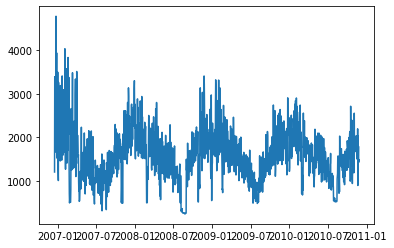

In [11]:
plt.plot(df_d.index,df_d.Global_active_power)

In [12]:
df.corr()

# correlation 

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
Global_active_power,1.000000,0.247017,-0.398231,0.998889,0.484401,0.434569,0.638555
Global_reactive_power,0.247017,1.000000,-0.111817,0.266120,0.123111,0.139231,0.089617
Voltage,-0.398231,-0.111817,1.000000,-0.409785,-0.195225,-0.166764,-0.267145
Global_intensity,0.998889,0.266120,-0.409785,1.000000,0.489298,0.440347,0.626543
Sub_metering_1,0.484401,0.123111,-0.195225,0.489298,1.000000,0.054721,0.102571
Sub_metering_2,0.434569,0.139231,-0.166764,0.440347,0.054721,1.000000,0.080872
Sub_metering_3,0.638555,0.089617,-0.267145,0.626543,0.102571,0.080872,1.000000


In [13]:
df_d.reset_index(inplace=True)

x_test = df_d.tail(365)
x_train = df_d[:-365]

In [14]:
dff = df_d[['datetime','Global_active_power']]
dfn = dff.rename(columns={"datetime": "ds", "Global_active_power": "y"})

# dropping and renaming

In [15]:
from fbprophet import Prophet
x_testu = dfn[-365:]
x_trainu = dfn[:-365]

In [16]:
model = Prophet() # created model using FaceBook Prophet

In [17]:
model.fit(x_trainu) # trained model

INFO:numexpr.utils:NumExpr defaulting to 2 threads.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [18]:
future = model.make_future_dataframe(periods=365 , freq= 'D' )
result = model.predict(future)

# used model to predict

In [19]:
result.shape

(1442, 19)

In [20]:
result.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2006-12-16,1650.071328,1885.615615,2997.242177,1650.071328,1650.071328,775.004842,775.004842,775.004842,245.813256,245.813256,245.813256,529.191586,529.191586,529.191586,0.0,0.0,0.0,2425.076170
1,2006-12-17,1649.910702,1863.375361,2978.366413,1649.910702,1649.910702,771.844221,771.844221,771.844221,228.519177,228.519177,228.519177,543.325044,543.325044,543.325044,0.0,0.0,0.0,2421.754924
2,2006-12-18,1649.750077,1461.740000,2602.094367,1649.750077,1649.750077,397.001867,397.001867,397.001867,-161.286790,-161.286790,-161.286790,558.288657,558.288657,558.288657,0.0,0.0,0.0,2046.751944
3,2006-12-19,1649.589452,1674.405949,2799.305031,1649.589452,1649.589452,544.306666,544.306666,544.306666,-29.332428,-29.332428,-29.332428,573.639094,573.639094,573.639094,0.0,0.0,0.0,2193.896118
4,2006-12-20,1649.428826,1666.140060,2796.006119,1649.428826,1649.428826,564.208290,564.208290,564.208290,-24.708851,-24.708851,-24.708851,588.917141,588.917141,588.917141,0.0,0.0,0.0,2213.637116


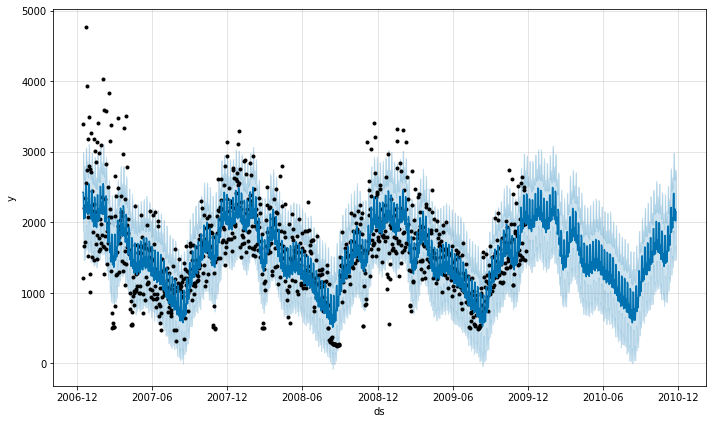

In [21]:
model.plot(result)
plt.show()

# plot of predictions

In [22]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [23]:
mean_absolute_percentage_error(x_testu['y'], result['yhat'][-365:])

20.815831963532684

In [24]:
from sklearn.metrics import mean_squared_error
from math import sqrt

rmse = sqrt(mean_squared_error(x_testu['y'], result['yhat'][-365:]))
print(rmse)

374.604233946713


In [38]:
import statsmodels.api as sm
from pylab import rcParams
rcParams['figure.figsize']= 12,7

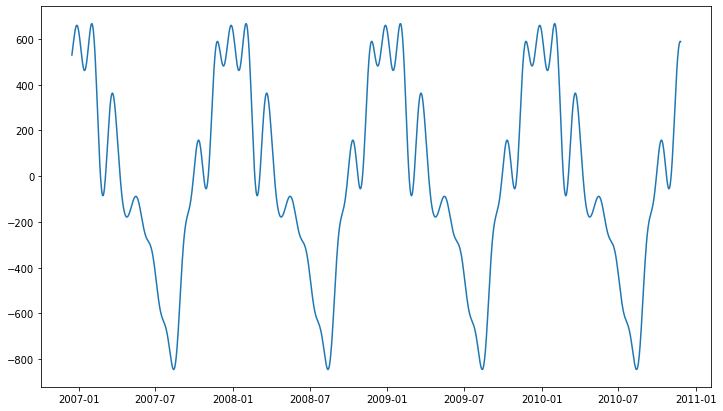

In [39]:
plt.plot(result['ds'],result['yearly'])
plt.show()

# yearly plot

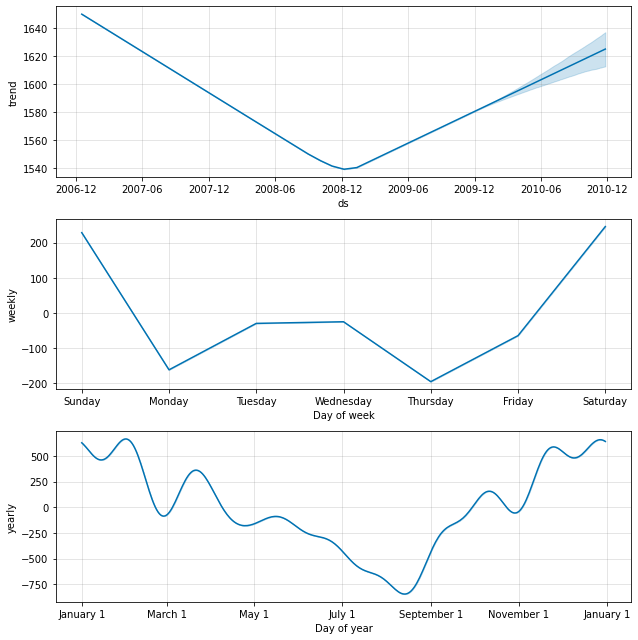

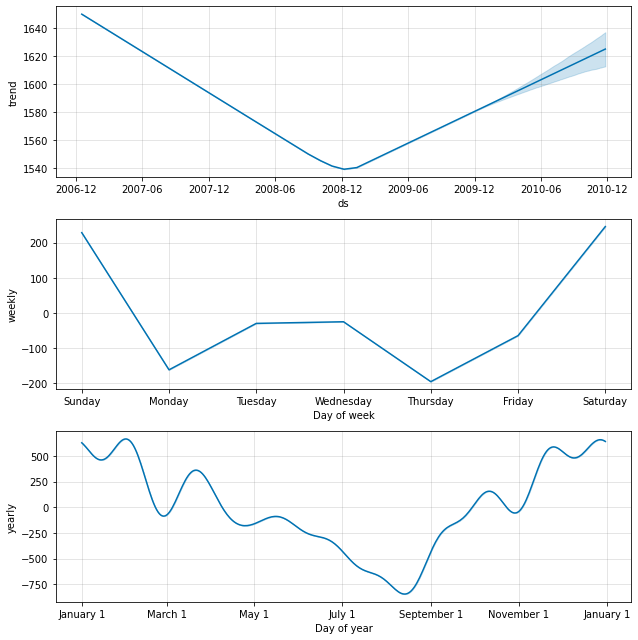

In [27]:
model.plot_components(result)

In [28]:
new_df = df_d.copy()
new_df= new_df.rename(columns={"datetime": "ds", "Global_active_power": "y","Global_reactive_power": "add1","Voltage": "add2","Global_intensity": "add3","Sub_metering_1": "add4","Sub_metering_2": "add5","Sub_metering_3": "add6"})

# multivariate case

In [29]:
x_testm = new_df.tail(365)
x_trainm = new_df[:-365]

In [30]:
model_multi = Prophet()
model_multi.add_regressor('add1')
model_multi.add_regressor('add2')
model_multi.add_regressor('add3')
model_multi.add_regressor('add4')
model_multi.add_regressor('add5')
model_multi.add_regressor('add6')

# adding regressors

In [31]:
model_multi.fit(x_trainm)

# fitting model

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [32]:
future_multi = model_multi.make_future_dataframe(periods=365,freq='D')
future_multi['add1'] = new_df['add1'].values
future_multi['add2'] = new_df['add2'].values
future_multi['add3'] = new_df['add3'].values
future_multi['add4'] = new_df['add4'].values
future_multi['add5'] = new_df['add5'].values
future_multi['add6'] = new_df['add6'].values
res = model_multi.predict(future_multi)

# using model to predict

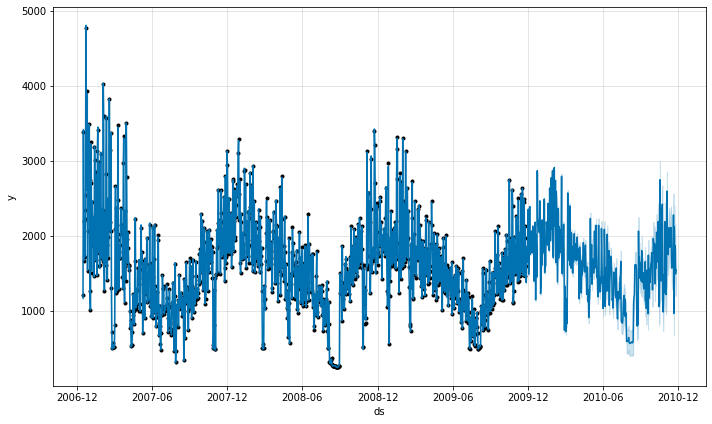

In [33]:
model_multi.plot(res)
plt.show()

# plot of model

In [34]:
mean_absolute_percentage_error( x_testm['y'][-365:], res['yhat'][-365:])

3.0445761457342444

In [35]:
sqrt(mean_squared_error( x_testm['y'][-365:], res['yhat'][-365:]))

44.87909204303396

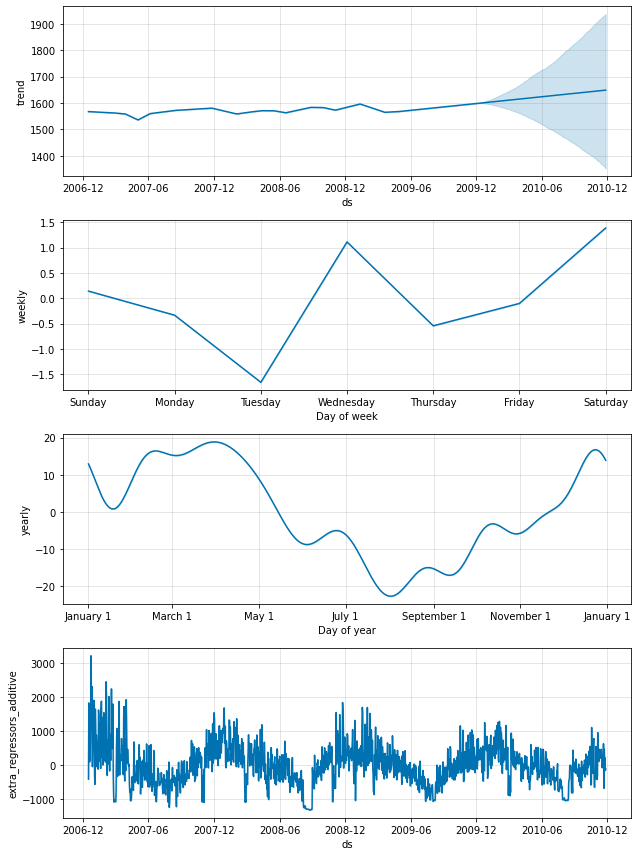

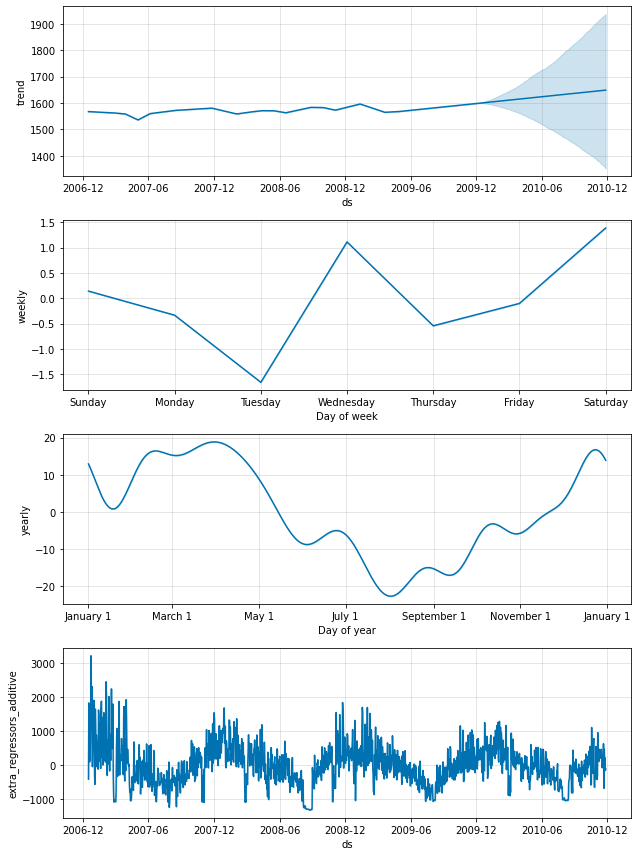

In [36]:
model_multi.plot_components(res) # component plots